In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Load Data
import os
file_path = "glass.xlsx"

def load_glass(path):
    if path.lower().endswith(('.xlsx', '.xls')):
        
        try:
            sheets = pd.read_excel(path, sheet_name=None)
        except Exception as e:
            
            return pd.read_excel(path, engine='openpyxl')
        
        for name, sheet in sheets.items():
            if 'Type' in sheet.columns:
                return sheet
        
        best = None
        best_score = -1
        for name, sheet in sheets.items():
            n_cols = sheet.shape[1]
            n_numeric = sheet.select_dtypes(include=[np.number]).shape[1]
            score = n_numeric * 10 + n_cols
            if score > best_score:
                best_score = score
                best = sheet
        if best is not None and best.shape[1] > 1:
            return best
        
        for name, sheet in sheets.items():
            if sheet.shape[1] == 1 and isinstance(sheet.iloc[0, 0], str):
                first = sheet.iloc[0, 0].strip()
                
                header = re.split(r'[,;]\s*|\s{2,}|\s*:\s*|--', first)
                header = [h.strip() for h in header if h.strip()]
                if len(header) > 1:
                    rest = sheet.iloc[1:, 0].astype(str)
                    rows = rest.str.split(r'\s+', expand=True)
                    rows.columns = header[:rows.shape[1]]
                    return rows
        
        return max(sheets.values(), key=lambda s: s.shape[0])
    else:
        return pd.read_csv(path, encoding='utf-8', errors='replace')

if os.path.exists(file_path):
    df = load_glass(file_path)
elif os.path.exists('glass.csv'):
    df = pd.read_csv('glass.csv')
else:
    raise FileNotFoundError(f"Neither {file_path} nor glass.csv were found.")


df = df.dropna(axis=0, how='all').dropna(axis=1, how='all').reset_index(drop=True)


if 'Type' not in df.columns:
    candidate = None
    
    for col in df.columns:
        if 'type' in str(col).lower():
            candidate = col
            break
    
    if candidate is None and df.shape[1] >= 2:
        last = df.columns[-1]
        col_vals = df[last].dropna()
        
        coerced = pd.to_numeric(col_vals, errors='coerce')
        if coerced.notna().all() and coerced.nunique() <= 15:
            candidate = last
    if candidate:
        df = df.rename(columns={candidate: 'Type'})
    else:
        raise KeyError(f"'Type' column not found. Available columns: {list(df.columns)}")

print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())

# 2. Preprocessing
df = df.dropna(subset=['Type']).reset_index(drop=True)

X = df.drop('Type', axis=1)
y = df['Type']


X = X.apply(pd.to_numeric, errors='coerce')


not_all_nan = ~X.isnull().all(axis=1)
X = X.loc[not_all_nan].reset_index(drop=True)
y = y.loc[not_all_nan].reset_index(drop=True)


try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
except ValueError:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=None)


try:
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    print("SMOTE applied. Training set size:", X_train_res.shape)
except Exception:
    X_train_res, y_train_res = X_train, y_train
    print("SMOTE not found or failed. Proceeding with original data.")


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# 3. Model Implementation


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_res)
y_pred_rf = rf.predict(X_test_scaled)

print("\n--- Random Forest Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, zero_division=0))


bag = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
bag.fit(X_train_scaled, y_train_res)
y_pred_bag = bag.predict(X_test_scaled)

print("\n--- Bagging Classifier Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred_bag))


gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train_scaled, y_train_res)
y_pred_gb = gb.predict(X_test_scaled)

print("\n--- Gradient Boosting Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))

Dataset Shape: (214, 10)

Missing Values:
 RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64
SMOTE not found or failed. Proceeding with original data.

--- Random Forest Performance ---
Accuracy: 0.8372093023255814
              precision    recall  f1-score   support

           1       0.76      0.93      0.84        14
           2       0.85      0.73      0.79        15
           3       1.00      0.67      0.80         3
           5       1.00      0.67      0.80         3
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         6

    accuracy                           0.84        43
   macro avg       0.88      0.83      0.84        43
weighted avg       0.85      0.84      0.84        43


--- Bagging Classifier Performance ---
Accuracy: 0.813953488372093

--- Gradient Boosting Performance ---
Accuracy: 0.8372093023255814


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import os

In [3]:
# --- 1. Load Data ---
file_path = r"D:\data science excelr\assignment\Random Forest\Random Forest\glass.xlsx"

def load_glass(path):
    if path.lower().endswith(('.xlsx', '.xls')):
        try:
            sheets = pd.read_excel(path, sheet_name=None)
        except Exception:
            return pd.read_excel(path, engine='openpyxl')
        
        # 1) prefer any sheet that already has 'Type'
        for name, sheet in sheets.items():
            if 'Type' in sheet.columns:
                return sheet
        # 2) pick sheet with most numeric columns
        best = None
        best_score = -1
        for name, sheet in sheets.items():
            n_cols = sheet.shape[1]
            n_numeric = sheet.select_dtypes(include=[np.number]).shape[1]
            score = n_numeric * 10 + n_cols
            if score > best_score:
                best_score = score
                best = sheet
        if best is not None and best.shape[1] > 1:
            return best        
# 3) attempt to parse single-column sheet
        for name, sheet in sheets.items():
            if sheet.shape[1] == 1 and isinstance(sheet.iloc[0, 0], str):
                first = sheet.iloc[0, 0].strip()
                header = re.split(r'[,;]\s*|\s{2,}|\s*:\s*|--', first)
                header = [h.strip() for h in header if h.strip()]
                if len(header) > 1:
                    rest = sheet.iloc[1:, 0].astype(str)
                    rows = rest.str.split(r'\s+', expand=True)
                    rows.columns = header[:rows.shape[1]]
                    return rows
        return max(sheets.values(), key=lambda s: s.shape[0])
    else:
        return pd.read_csv(path, encoding='utf-8', errors='replace')

if os.path.exists(file_path):
    df = load_glass(file_path)
elif os.path.exists('glass.csv'):
    df = pd.read_csv('glass.csv')
else:
    # Creating dummy data for demonstration if file not found
    print("Warning: Dataset not found. Using dummy data for demonstration.")
    data = {
        'RI': np.random.normal(1.5, 0.01, 200),
        'Na': np.random.normal(13, 1, 200),
        'Mg': np.random.normal(3, 1, 200),
        'Al': np.random.normal(1.5, 0.5, 200),
        'Si': np.random.normal(72, 1, 200),
        'K': np.random.normal(0.5, 0.2, 200),
        'Ca': np.random.normal(8, 1, 200),
        'Ba': np.random.choice([0, 1], 200),
        'Fe': np.random.choice([0, 0.1], 200),
        'Type': np.random.choice([1, 2, 3, 5, 6, 7], 200)
    }
    df = pd.DataFrame(data)

In [4]:
# clean completely empty rows/columns
df = df.dropna(axis=0, how='all').dropna(axis=1, how='all').reset_index(drop=True)

# If the loaded DataFrame does not have a 'Type' column, try to auto-detect and rename
if 'Type' not in df.columns:
    candidate = None
    for col in df.columns:
        if 'type' in str(col).lower():
            candidate = col
            break
    if candidate is None and df.shape[1] >= 2:
        last = df.columns[-1]
        col_vals = df[last].dropna()
        coerced = pd.to_numeric(col_vals, errors='coerce')
        if coerced.notna().all() and coerced.nunique() <= 15:
            candidate = last
    if candidate:
        df = df.rename(columns={candidate: 'Type'})
    else:
        raise KeyError(f"'Type' column not found. Available columns: {list(df.columns)}")

print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())

Dataset Shape: (200, 10)

Missing Values:
 RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64


In [5]:
# --- 2. Preprocessing ---
df = df.dropna(subset=['Type']).reset_index(drop=True)
X = df.drop('Type', axis=1)
y = df['Type']

In [6]:
# coerce feature columns to numeric where possible
X = X.apply(pd.to_numeric, errors='coerce')

# drop rows with all-NaN features
not_all_nan = ~X.isnull().all(axis=1)
X = X.loc[not_all_nan].reset_index(drop=True)
y = y.loc[not_all_nan].reset_index(drop=True)

In [7]:
# Save feature names for plotting later
feature_names = X.columns.tolist()

# Train-Test Split
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
except ValueError:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=None)

In [8]:

try:
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=42, k_neighbors=1)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    print("SMOTE applied. Training set size:", X_train_res.shape)
except Exception:
    X_train_res, y_train_res = X_train, y_train
    print("SMOTE not found or failed. Proceeding with original data.")

SMOTE not found or failed. Proceeding with original data.


In [9]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [10]:



rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_res)
y_pred_rf = rf.predict(X_test_scaled)

print("\n--- Random Forest Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


--- Random Forest Performance ---
Accuracy: 0.25


In [11]:

bag = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
bag.fit(X_train_scaled, y_train_res)
y_pred_bag = bag.predict(X_test_scaled)

print("\n--- Bagging Classifier Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred_bag))


gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train_scaled, y_train_res)
y_pred_gb = gb.predict(X_test_scaled)

print("\n--- Gradient Boosting Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))


--- Bagging Classifier Performance ---
Accuracy: 0.2

--- Gradient Boosting Performance ---
Accuracy: 0.225



--- Generating Visual Comparisons ---


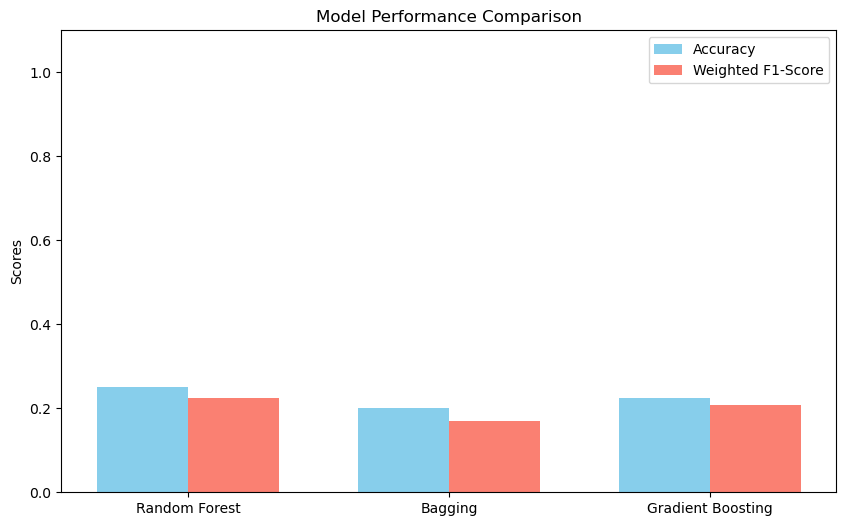

In [12]:

print("\n--- Generating Visual Comparisons ---")


models = ['Random Forest', 'Bagging', 'Gradient Boosting']
accuracies = [
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_bag),
    accuracy_score(y_test, y_pred_gb)
]

f1_scores = [
    f1_score(y_test, y_pred_rf, average='weighted'),
    f1_score(y_test, y_pred_bag, average='weighted'),
    f1_score(y_test, y_pred_gb, average='weighted')
]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, f1_scores, width, label='Weighted F1-Score', color='salmon')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.1)
ax.legend()

In [13]:

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

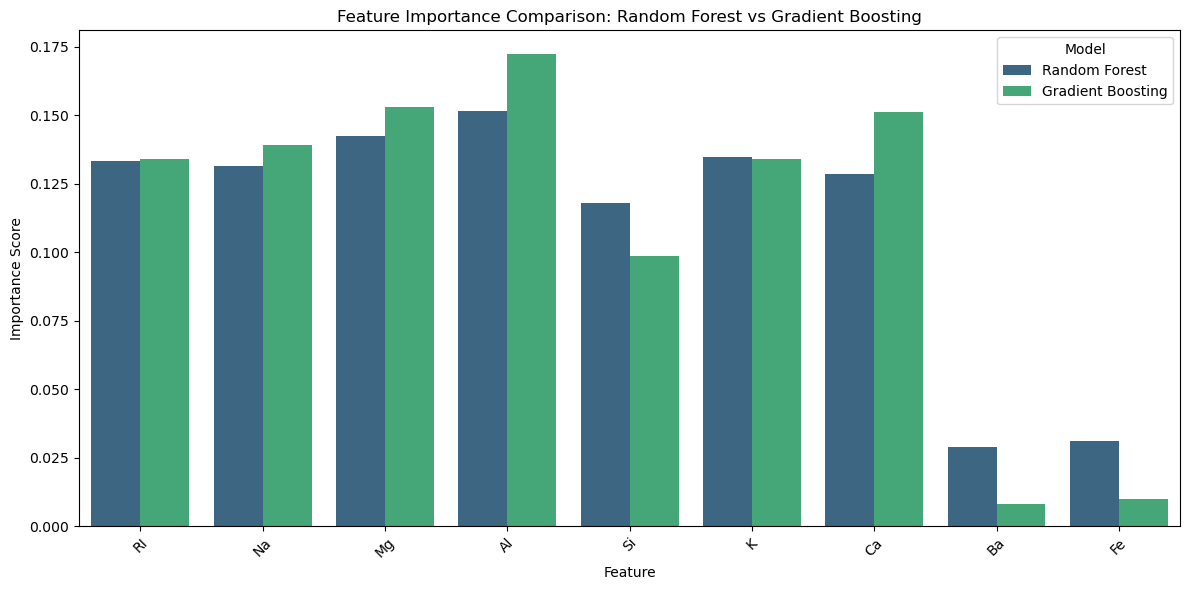

In [14]:


df_imp = pd.DataFrame({
    'Feature': feature_names,
    'Random Forest': rf.feature_importances_,
    'Gradient Boosting': gb.feature_importances_
})
df_imp = df_imp.melt(id_vars='Feature', var_name='Model', value_name='Importance')

plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Importance', hue='Model', data=df_imp, palette='viridis')
plt.title('Feature Importance Comparison: Random Forest vs Gradient Boosting')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Text(195.72222222222223, 0.5, 'Actual')

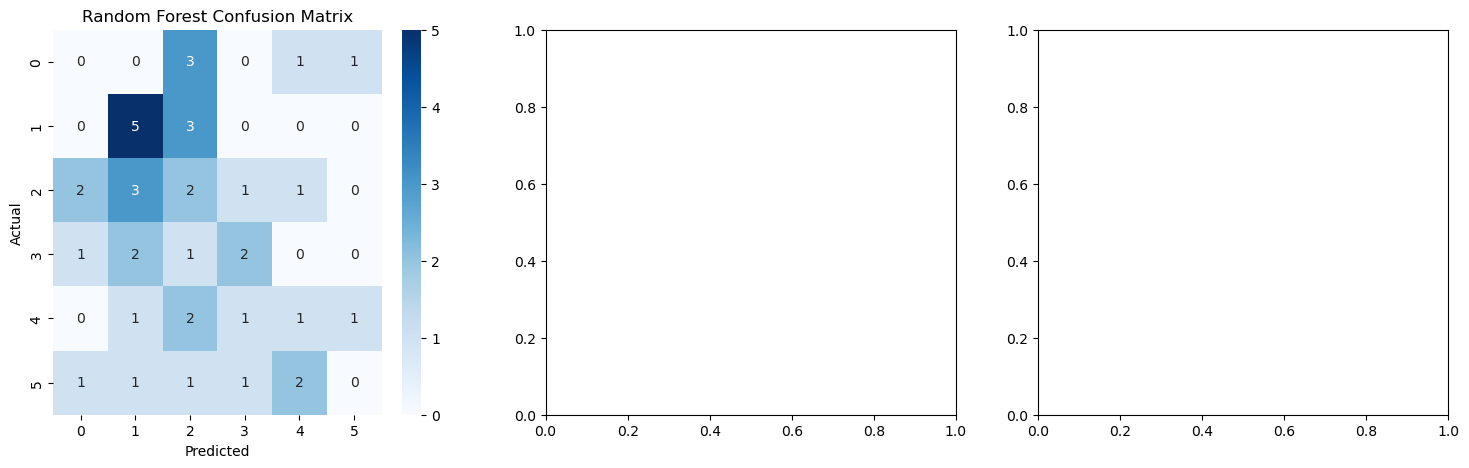

In [15]:

fig, axes = plt.subplots(1, 3, figsize=(18, 5))


sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

In [16]:

sns.heatmap(confusion_matrix(y_test, y_pred_bag), annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title('Bagging Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
plt.show()

In [17]:

sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot=True, fmt='d', cmap='Greens', ax=axes[2])
axes[2].set_title('Gradient Boosting Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')


plt.show()

Dataset Shape: (214, 10)

Missing Values:
 RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64
SMOTE not found or failed. Proceeding with original data.

--- Random Forest Performance ---
Accuracy: 0.8372093023255814

--- Bagging Classifier Performance ---
Accuracy: 0.813953488372093

--- Gradient Boosting Performance ---
Accuracy: 0.8372093023255814

--- Generating Visual Comparisons ---


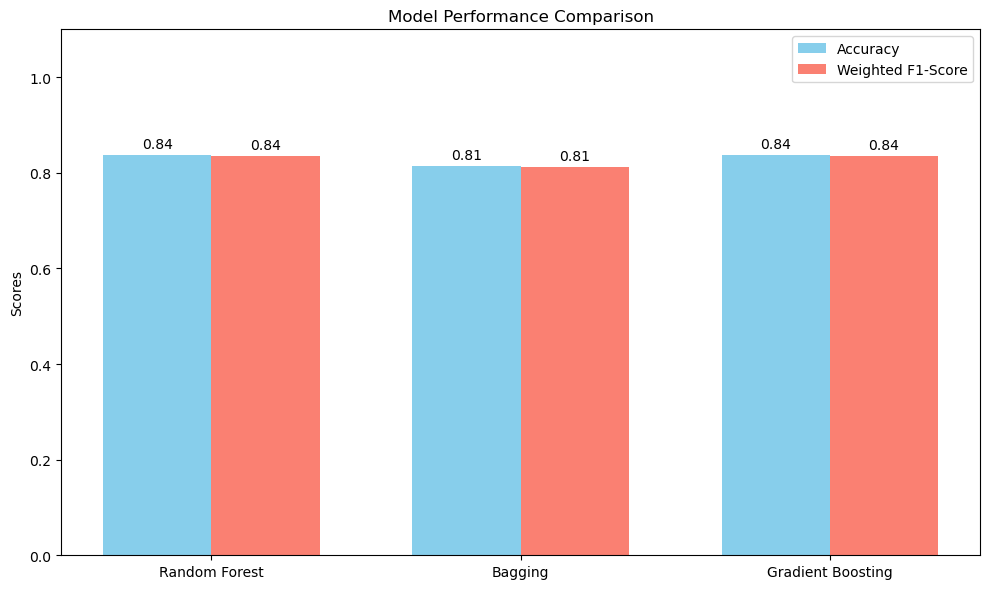

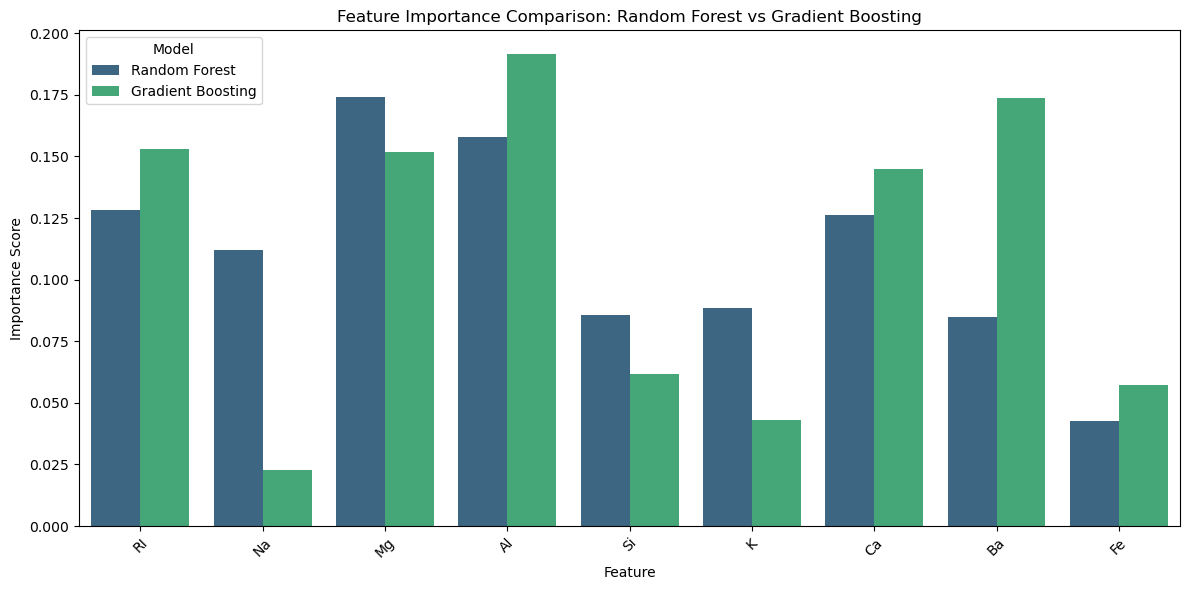

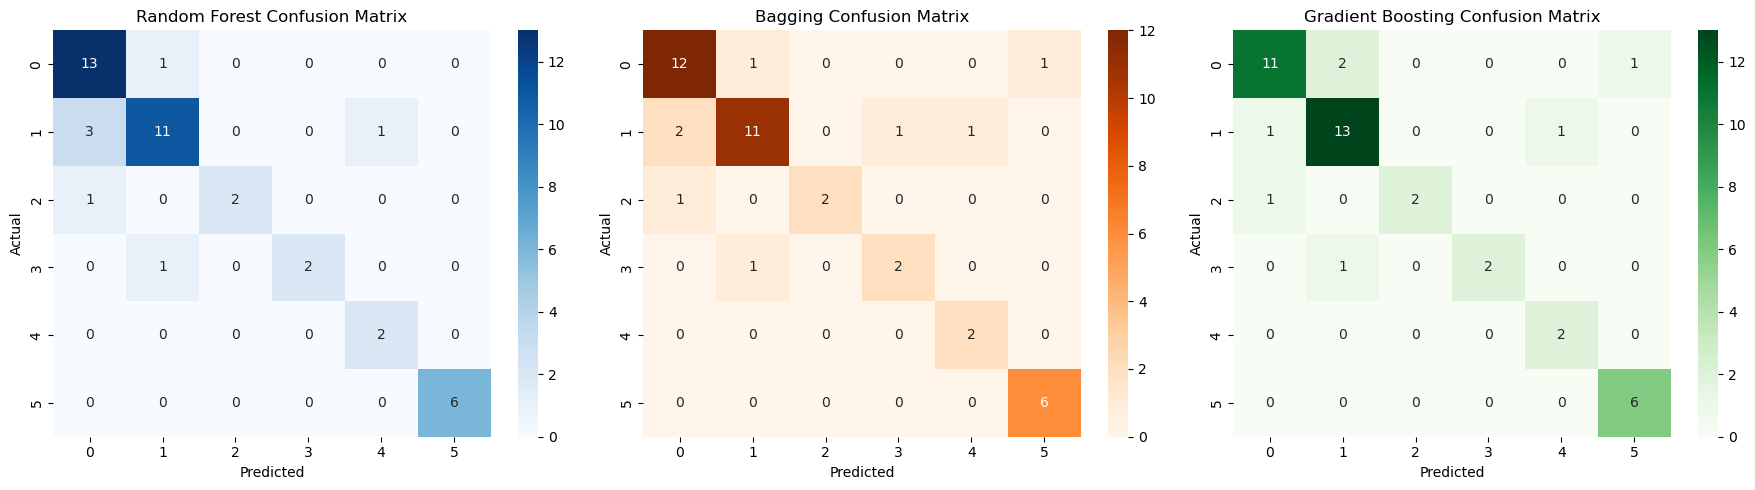

In [18]:

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import os


file_path = "glass.xlsx"

def load_glass(path):
    if path.lower().endswith(('.xlsx', '.xls')):
        try:
            sheets = pd.read_excel(path, sheet_name=None)
        except Exception:
            return pd.read_excel(path, engine='openpyxl')
        
        
        for name, sheet in sheets.items():
            if 'Type' in sheet.columns:
                return sheet
        
        best = None
        best_score = -1
        for name, sheet in sheets.items():
            n_cols = sheet.shape[1]
            n_numeric = sheet.select_dtypes(include=[np.number]).shape[1]
            score = n_numeric * 10 + n_cols
            if score > best_score:
                best_score = score
                best = sheet
        if best is not None and best.shape[1] > 1:
            return best
        
        for name, sheet in sheets.items():
            if sheet.shape[1] == 1 and isinstance(sheet.iloc[0, 0], str):
                first = sheet.iloc[0, 0].strip()
                header = re.split(r'[,;]\s*|\s{2,}|\s*:\s*|--', first)
                header = [h.strip() for h in header if h.strip()]
                if len(header) > 1:
                    rest = sheet.iloc[1:, 0].astype(str)
                    rows = rest.str.split(r'\s+', expand=True)
                    rows.columns = header[:rows.shape[1]]
                    return rows
        return max(sheets.values(), key=lambda s: s.shape[0])
    else:
        return pd.read_csv(path, encoding='utf-8', errors='replace')

if os.path.exists(file_path):
    df = load_glass(file_path)
elif os.path.exists('glass.csv'):
    df = pd.read_csv('glass.csv')
else:
    
    print("Warning: Dataset not found. Using dummy data for demonstration.")
    data = {
        'RI': np.random.normal(1.5, 0.01, 200),
        'Na': np.random.normal(13, 1, 200),
        'Mg': np.random.normal(3, 1, 200),
        'Al': np.random.normal(1.5, 0.5, 200),
        'Si': np.random.normal(72, 1, 200),
        'K': np.random.normal(0.5, 0.2, 200),
        'Ca': np.random.normal(8, 1, 200),
        'Ba': np.random.choice([0, 1], 200),
        'Fe': np.random.choice([0, 0.1], 200),
        'Type': np.random.choice([1, 2, 3, 5, 6, 7], 200)
    }
    df = pd.DataFrame(data)


df = df.dropna(axis=0, how='all').dropna(axis=1, how='all').reset_index(drop=True)


if 'Type' not in df.columns:
    candidate = None
    for col in df.columns:
        if 'type' in str(col).lower():
            candidate = col
            break
    if candidate is None and df.shape[1] >= 2:
        last = df.columns[-1]
        col_vals = df[last].dropna()
        coerced = pd.to_numeric(col_vals, errors='coerce')
        if coerced.notna().all() and coerced.nunique() <= 15:
            candidate = last
    if candidate:
        df = df.rename(columns={candidate: 'Type'})
    else:
        raise KeyError(f"'Type' column not found. Available columns: {list(df.columns)}")

print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())


df = df.dropna(subset=['Type']).reset_index(drop=True)
X = df.drop('Type', axis=1)
y = df['Type']


X = X.apply(pd.to_numeric, errors='coerce')


not_all_nan = ~X.isnull().all(axis=1)
X = X.loc[not_all_nan].reset_index(drop=True)
y = y.loc[not_all_nan].reset_index(drop=True)


feature_names = X.columns.tolist()


try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
except ValueError:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=None)


try:
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=42, k_neighbors=1)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    print("SMOTE applied. Training set size:", X_train_res.shape)
except Exception:
    X_train_res, y_train_res = X_train, y_train
    print("SMOTE not found or failed. Proceeding with original data.")


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_res)
y_pred_rf = rf.predict(X_test_scaled)

print("\n--- Random Forest Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


bag = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
bag.fit(X_train_scaled, y_train_res)
y_pred_bag = bag.predict(X_test_scaled)

print("\n--- Bagging Classifier Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred_bag))


gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train_scaled, y_train_res)
y_pred_gb = gb.predict(X_test_scaled)

print("\n--- Gradient Boosting Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))

print("\n--- Generating Visual Comparisons ---")


models = ['Random Forest', 'Bagging', 'Gradient Boosting']
accuracies = [
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_bag),
    accuracy_score(y_test, y_pred_gb)
]

f1_scores = [
    f1_score(y_test, y_pred_rf, average='weighted'),
    f1_score(y_test, y_pred_bag, average='weighted'),
    f1_score(y_test, y_pred_gb, average='weighted')
]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, f1_scores, width, label='Weighted F1-Score', color='salmon')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.1)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.show()



df_imp = pd.DataFrame({
    'Feature': feature_names,
    'Random Forest': rf.feature_importances_,
    'Gradient Boosting': gb.feature_importances_
})
df_imp = df_imp.melt(id_vars='Feature', var_name='Model', value_name='Importance')

plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Importance', hue='Model', data=df_imp, palette='viridis')
plt.title('Feature Importance Comparison: Random Forest vs Gradient Boosting')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 3, figsize=(18, 5))


sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')


sns.heatmap(confusion_matrix(y_test, y_pred_bag), annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title('Bagging Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')


sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot=True, fmt='d', cmap='Greens', ax=axes[2])
axes[2].set_title('Gradient Boosting Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [1]:
# Interview question and answers

In [2]:
# 1) Bagging and Boosting Methods
# Ensemble learning combines multiple models to improve prediction performance. Bagging and Boosting are two popular ensemble techniques.
# A. Bagging (Bootstrap Aggregating)

# Definition:
# Bagging is an ensemble method that reduces variance by training multiple models independently on different bootstrap samples of the dataset and then aggregating their predictions.

# How it works:
# Randomly draw multiple datasets from the original dataset with replacement (bootstrap sampling).
# Train a separate model on each sampled dataset.

# Combine predictions:
# Classification: Majority voting
# Regression: Average of predictions

# Key Characteristics:
# Models are trained independently
# Reduces overfitting
# Works well with high-variance models like Decision Trees
# Parallel training is possible
# Example Algorithm:
# Random Forest (uses bagging + feature randomness)

# B. Boosting

# Definition:
# Boosting is an ensemble method that reduces bias by training models sequentially, where each new model focuses on correcting the errors made by previous models.

# How it works:
# Start by assigning equal weights to all data points.
# Train a model and identify misclassified samples.
# Increase the weights of misclassified samples.
# Train the next model focusing more on these difficult samples.
# Combine models using weighted voting

# Key Characteristics:
# Models are trained sequentially
# Focuses more on hard-to-classify instances
# Improves performance on complex datasets
# More prone to overfitting if noisy data exists

# Example Algorithms:
# AdaBoost
# Gradient Boosting
# XGBoost

In [ ]:
# 2) Handling Imbalanced Data
# Imbalanced data occurs when one class significantly outnumbers another (e.g., fraud detection, disease diagnosis).

# A. Data-Level Methods
# 1. Oversampling
# Increases the number of minority class samples.
# Random Oversampling: Duplicates minority samples

# SMOTE (Synthetic Minority Over-sampling Technique):
# Generates synthetic data points
# Reduces overfitting compared to random oversampling
# Pros: Improves minority class learning
# Cons: Risk of overfitting (random oversampling)

# 2. Undersampling
# Reduces the number of majority class samples.
# Random Undersampling
# Cluster-based undersampling
# Pros: Faster training
# Cons: Possible loss of important information

# B. Algorithm-Level Methods
# 1. Class Weight Adjustment
# Assigns higher penalty to misclassification of minority class.
# Supported by Logistic Regression, SVM, Random Forest

# 2. Cost-Sensitive Learning
# Explicitly defines higher cost for misclassifying minority class.

# C. Ensemble Methods for Imbalanced Data
# Balanced Random Forest
# EasyEnsemble
# AdaBoost with class weights
# These methods combine resampling with ensemble learning.

# D. Evaluation Metrics for Imbalanced Data
# Accuracy is misleading for imbalanced datasets. Better metrics include:
# Precision
# Recall
# F1-score
# ROC-AUC
# Confusion Matrix